In [1]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import imprint as ip

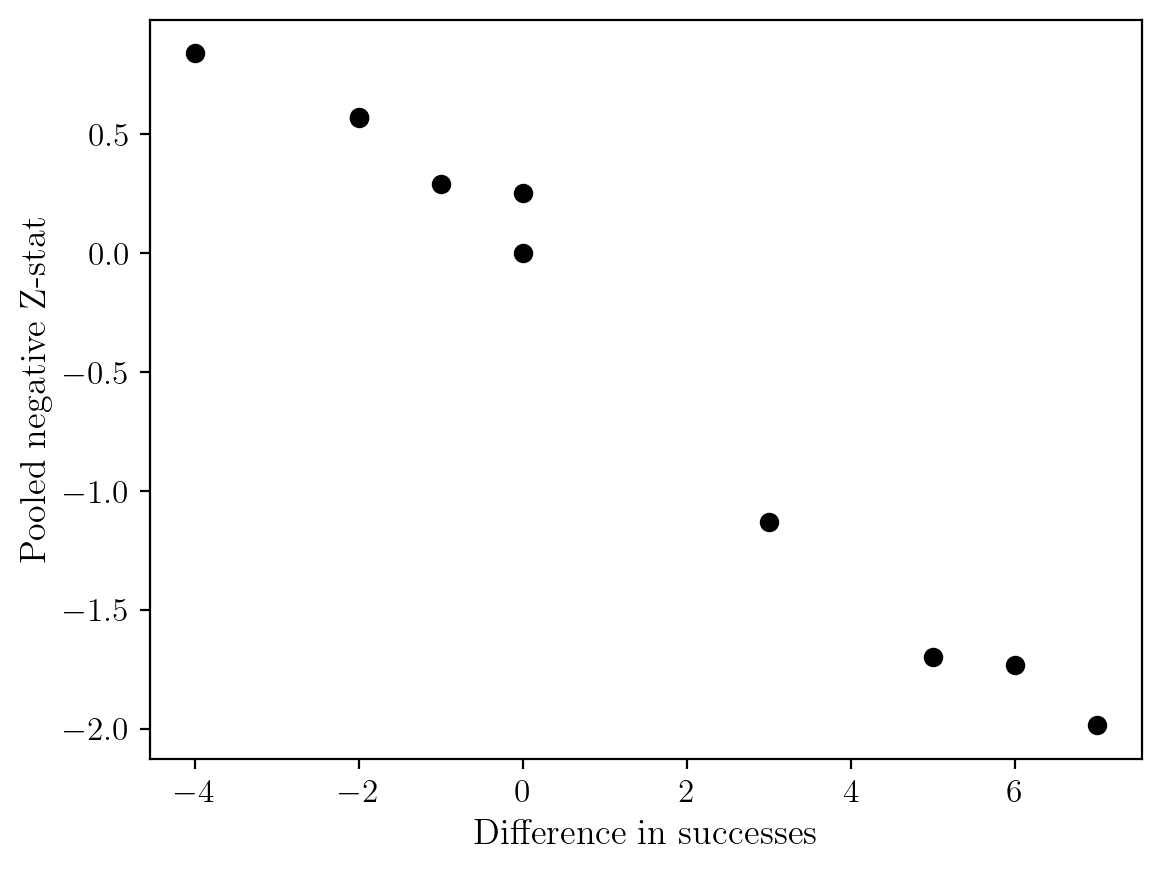

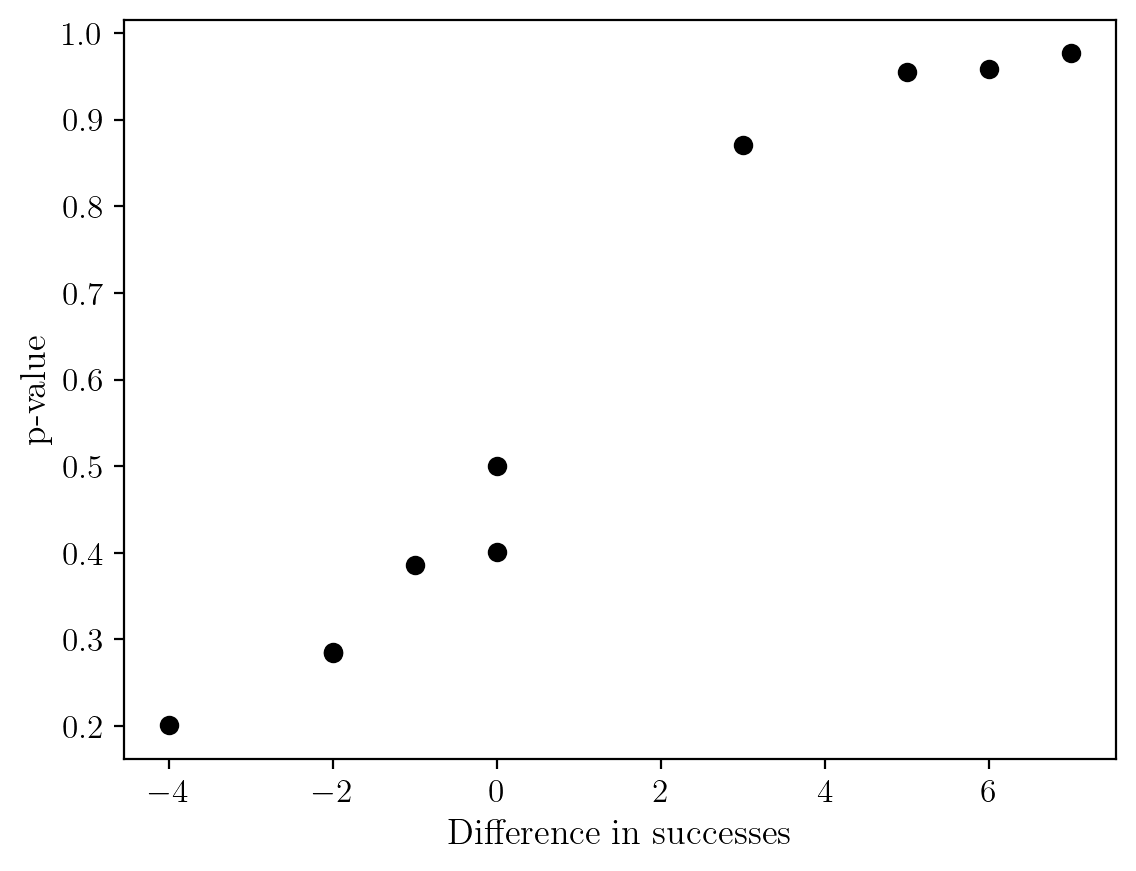

In [2]:

@jax.jit
def _sim(outcome_samples, assignment, arm_counts, theta, null_truth):
    p = jax.scipy.special.expit(theta)
    assigned_p = jnp.take(p, assignment, axis=1)
    S = outcome_samples[None] < assigned_p
    successes = jnp.stack(
        [jnp.sum(S * (assignment[None] == i), axis=-1) for i in range(2)], axis=-1
    )
    pihat = successes / arm_counts[None, :, :]
    phat = jnp.sum(successes, axis=-1) / jnp.sum(arm_counts, axis=-1)
    Zpooled = (pihat[..., 1] - pihat[..., 0]) / jnp.sqrt(
        phat * (1 - phat) * (1 / arm_counts[..., 0] + 1 / arm_counts[..., 1])
    )
    eps = 1e-10
    Zpooled = jnp.where(
        (phat > eps) & (phat < (1 - eps)) & null_truth[:, 0, None], Zpooled, jnp.inf
    )
    pvalue = 1 - jax.scipy.stats.norm.cdf(Zpooled)
    return pvalue, Zpooled, successes


class Efron:
    def __init__(self, seed, max_K, *, n_patients):
        self.seed = seed
        self.max_K = max_K
        self.family = "binomial"
        self.family_params = {"n": n_patients}
        self.dtype = jnp.float64

        key = jax.random.PRNGKey(self.seed)
        key1, key2 = jax.random.split(key)
        self.outcome_samples = jax.random.uniform(
            key1, shape=(max_K, n_patients), dtype=self.dtype
        )
        self.assignment_samples = jax.random.uniform(
            key2, shape=(max_K, n_patients), dtype=self.dtype
        )
        self.arm_counts = np.zeros((max_K, 2))
        self.assignment = np.empty((max_K, n_patients), dtype=np.int32)
        for i in range(n_patients):
            arm0_prob = np.where(
                self.arm_counts[:, 0] == self.arm_counts[:, 1],
                0.5,
                np.where(
                    self.arm_counts[:, 0] < self.arm_counts[:, 1], 1.0 / 3.0, 2.0 / 3.0
                ),
            )
            self.assignment[:, i] = self.assignment_samples[:, i] < arm0_prob
            self.arm_counts[np.arange(max_K), self.assignment[:, i]] += 1
        self.assignment = jnp.array(self.assignment)

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return _sim(*self.args(begin_sim, end_sim, theta, null_truth))[0]
            
    def args(self, begin_sim, end_sim, theta, null_truth):
        return (
            self.outcome_samples[begin_sim:end_sim],
            self.assignment[begin_sim:end_sim],
            self.arm_counts[begin_sim:end_sim],
            theta,
            null_truth
        )

e = Efron(0, 10, n_patients=50)
theta = jnp.array([[0.0, 0.0]])
null_truth = jnp.array([[True]])
pvalue, Z, successes = _sim(*e.args(0, e.max_K, theta, null_truth))
diff = successes[0,..., 0] - successes[0,..., 1]

plt.plot(diff, Z[0], 'ko')
plt.xlabel("Difference in successes")
plt.ylabel("Pooled negative Z-stat")
plt.show()
plt.plot(diff, pvalue[0], 'ko')
plt.xlabel("Difference in successes")
plt.ylabel("p-value")
plt.show()

In [17]:
g = ip.cartesian_grid([-1, -1], [1, 1], n=[800, 800], null_hypos=[ip.hypo("theta0 > theta1")])
rej_df = ip.validate(Efron, g=g, lam=0.025, K=2**17, model_kwargs=dict(n_patients=40))

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=262143, worker_id=1, t=1674680586, n_bits=18, worker_bits=18) = [4402709127600799744 4402709127600799745 4402709127600799746, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=262143, worker_id=1, t=1674680587, n_bits=18, worker_bits=18) = [4402709196320276480 4402709196320276481 4402709196320276482, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=115714, worker_id=1, t=1674680588, n_bits=18, worker_bits=18) = [4402709265039753216 4402709265039753217 4402709265039753218, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1600, worker_id=1, t=1674680589, n_bits=18, worker_bits=18) = [4402709333759229952 4402709333759229953 4402709333759229954, ...]:


In [22]:
rej_df['tie_est'].max(), rej_df['tie_bound'].max()

(0.02683258, 0.028294843)

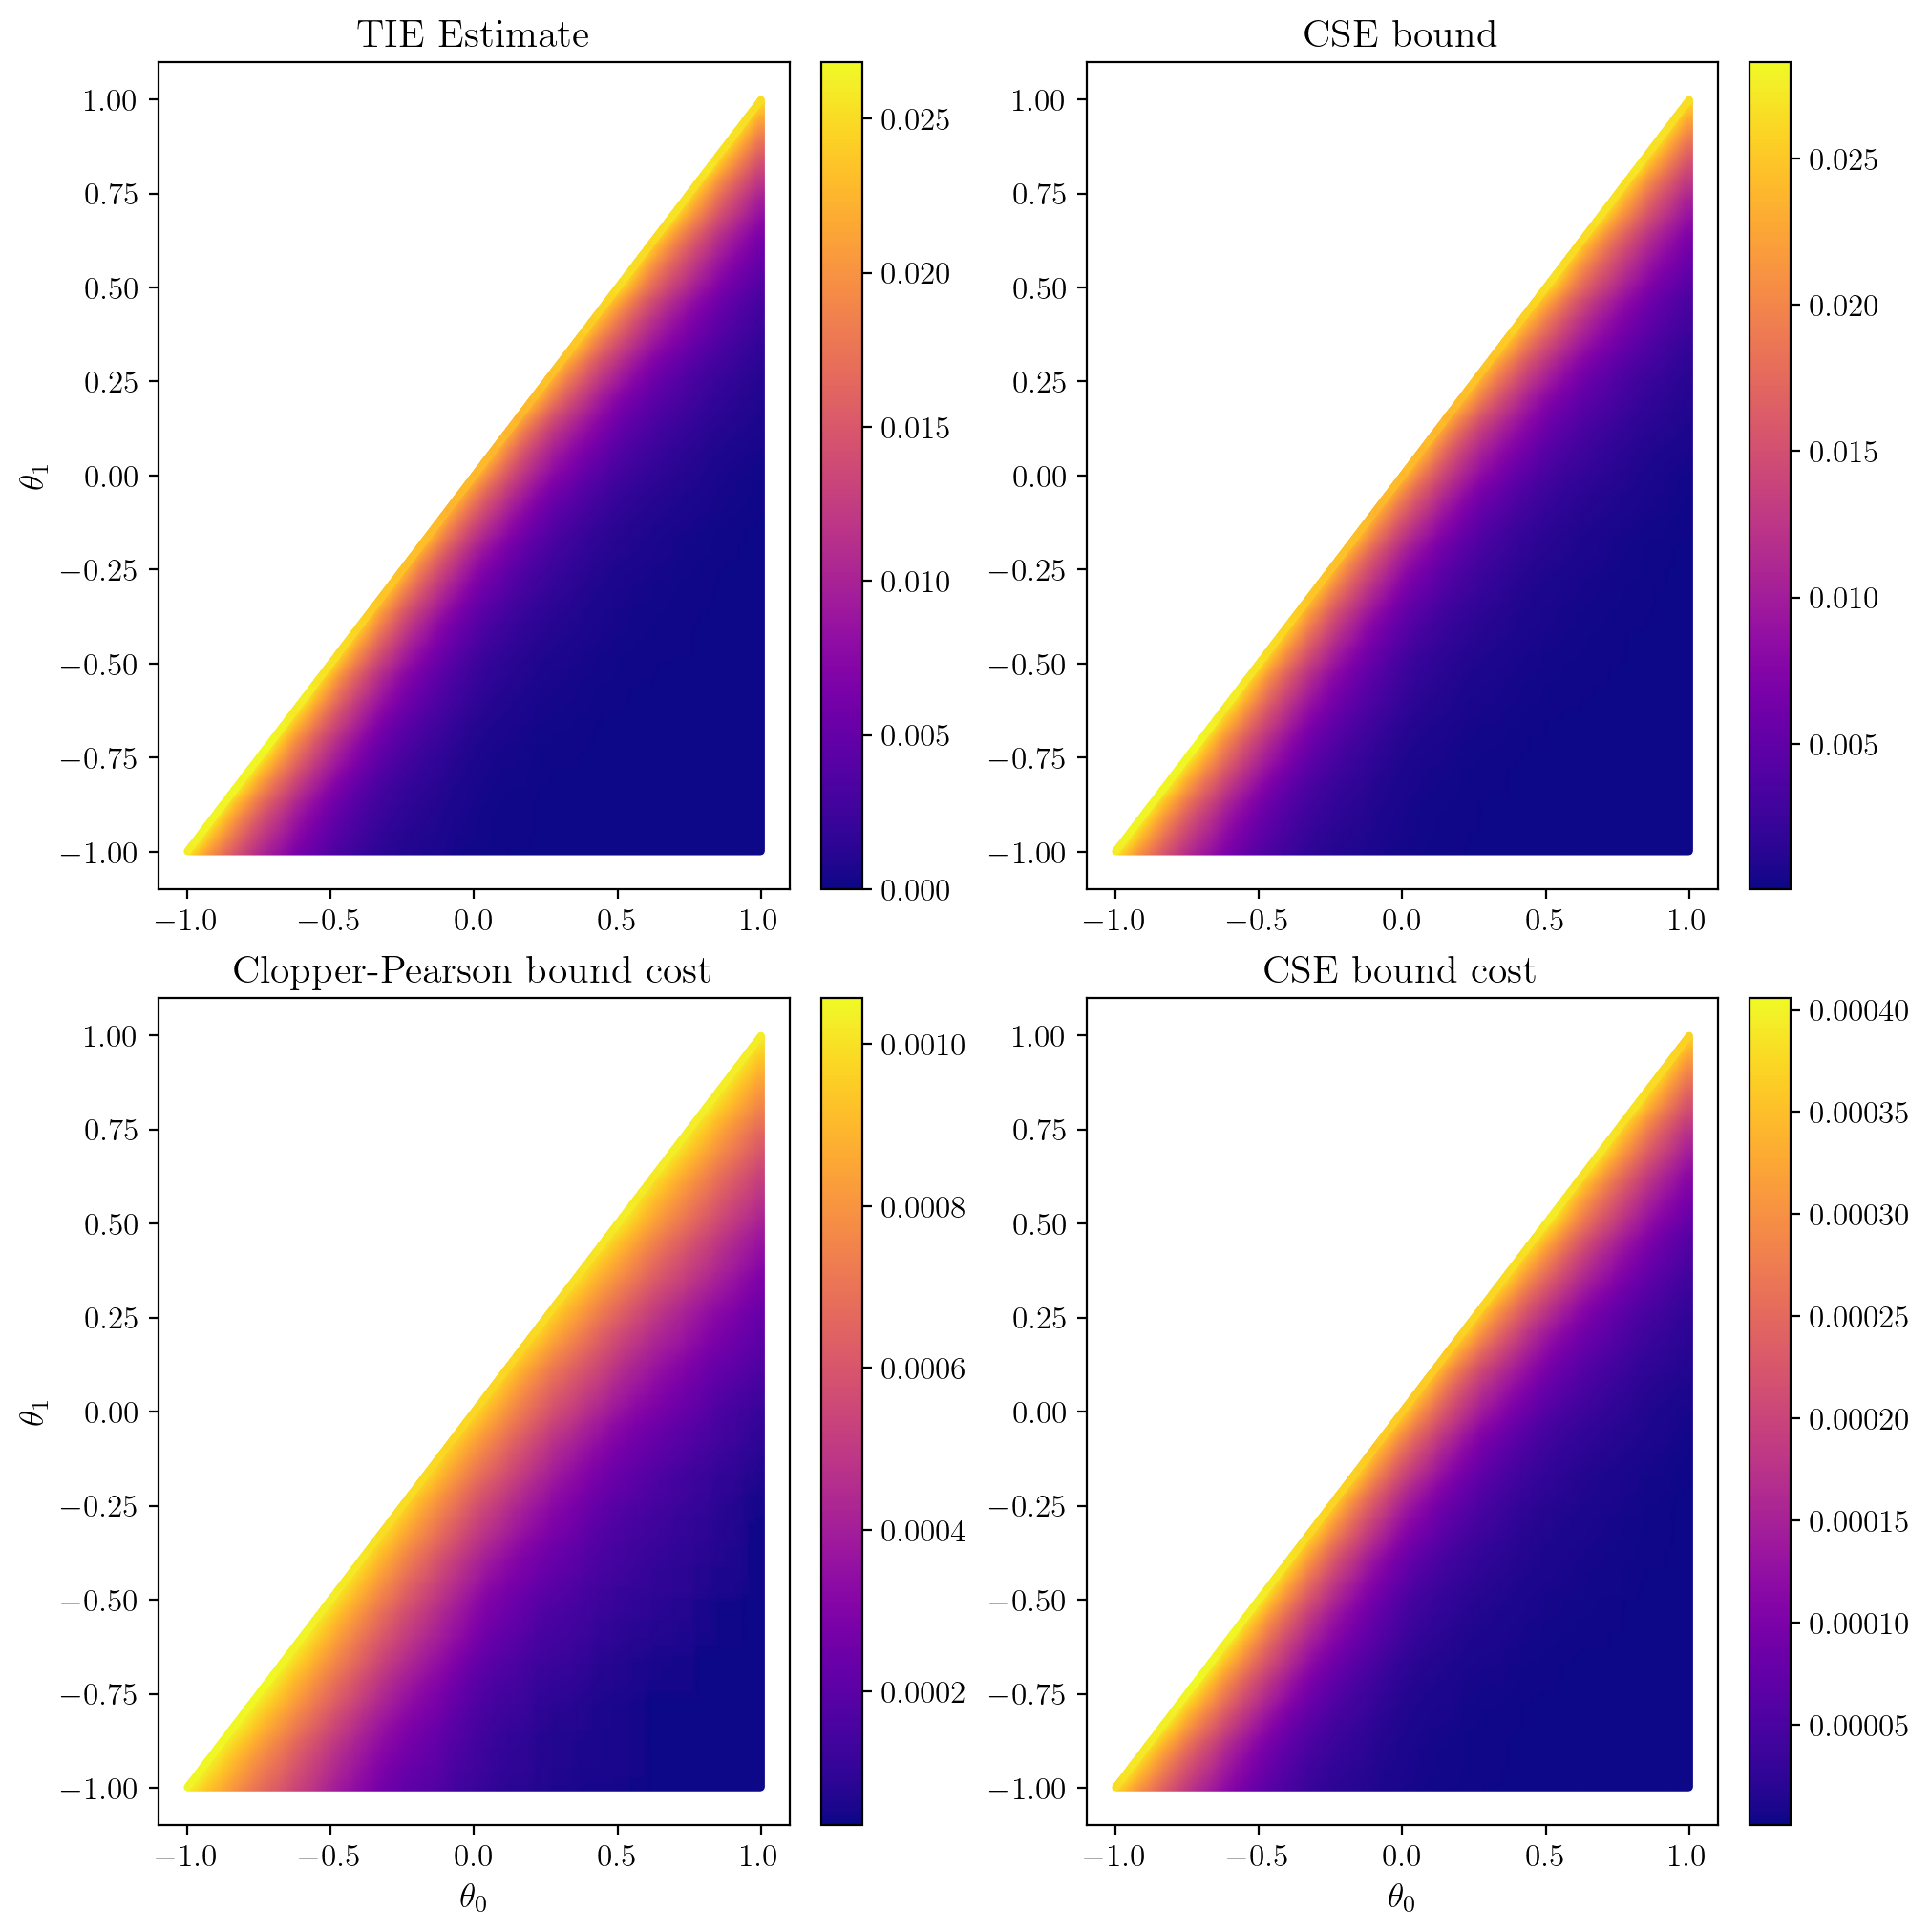

In [21]:
s = 3
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2,2,1)
plt.title('TIE Estimate')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'], s=s)
plt.colorbar()
plt.ylabel('$\\theta_1$')
plt.subplot(2,2,2)
plt.title('CSE bound')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_bound'], s=s)
plt.colorbar()
plt.subplot(2,2,3)
plt.title('Clopper-Pearson bound cost')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_cp_bound'] - rej_df['tie_est'], s=s)
plt.colorbar()
plt.xlabel('$\\theta_0$')
plt.ylabel('$\\theta_1$')
plt.subplot(2,2,4)
plt.title('CSE bound cost')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_bound'] - rej_df['tie_cp_bound'], s=s)
plt.colorbar()
plt.xlabel('$\\theta_0$')
plt.show()

In [29]:
lams_df = ip.calibrate(Efron, g=g, alpha=0.025, model_kwargs=dict(n_patients=40))

,lams
0,0.023352
1,0.027673
2,0.029165
3,0.038319
4,0.041391


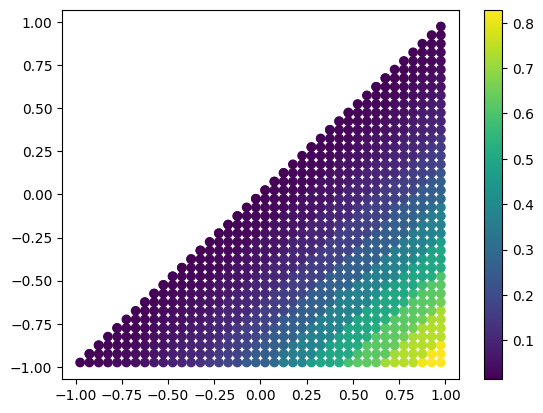

In [30]:
plt.scatter(g.df['theta0'], g.df['theta1'], c=lams_df['lams'])
plt.colorbar()
plt.show()

In [31]:
lams_df['lams'].min()

0.013994575

## Debugging version

In [3]:
n_patients = 50

# assignment RVs
phi = np.random.uniform(0, 1, n_patients)
arm_counts = [0, 0]
assignment = np.empty(n_patients, dtype=np.int32)
for i in range(n_patients):
    if arm_counts[0] == arm_counts[1]:
        # 50/50 chance of arm 0 and arm 1
        thresh = 0.5
    elif arm_counts[0] < arm_counts[1]:
        # 2/3rd chance of arm 0 and 1/3rds chance of arm 1
        thresh = 1.0 / 3.0
    else:
        # 1/3rd chance of arm 0 and 2/3rds chance of arm 1
        thresh = 2.0 / 3.0

    assignment[i] = int(phi[i] < thresh)
    arm_counts[assignment[i]] += 1

In [4]:
np.random.seed(0)
outcomes = np.random.uniform(0, 1, n_patients)
p = np.array([0.2, 0.4])
S = outcomes < p[assignment]
successes = np.array([np.sum(S * (assignment == i)) for i in range(2)])
successes

array([6, 4])

In [4]:
import imprint as ip
g = ip.cartesian_grid([-1], [1], n=[100], null_hypos=[ip.hypo("x < 0")])
tune_df = ip.calibrate(Efron, g, model_kwargs=dict(n=50))
lam = tune_df["lams"].min()
print(lam)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1674607310, n_bits=18, worker_bits=18) = [4397673639223492608 4397673639223492609 4397673639223492610, ...]:


0.19999999
